In [ ]:
# IMPORTING LIBRARIES
import os
import time
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset, random_split
from torchvision import datasets, transforms
import PIL

In [ ]:
# HELPER FUNCTIONS
def set_all_seeds(seed):
    os.environ["PL_GLOBAL_SEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def compute_accuracy(model, data_loader, device):
    with torch.no_grad():
        correct_pred, num_examples = 0, 0
        for i, (features, targets) in enumerate(data_loader):

            features = features.to(device)
            targets = targets.float().to(device)

            logits = model(features)
            _, predicted_labels = torch.max(logits, 1)

            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100

def plot_accuracy_test(train_acc_list, test_acc_list):
    train_acc_list = [acc.cpu().detach().numpy() if isinstance(acc, torch.Tensor) else acc for acc in train_acc_list]
    test_acc_list = [acc.cpu().detach().numpy() if isinstance(acc, torch.Tensor) else acc for acc in test_acc_list]

    num_epochs = len(train_acc_list)
    num_epochs = len(train_acc_list)

    plt.plot(np.arange(1, num_epochs+1),
             train_acc_list, label='Training')
    plt.plot(np.arange(1, num_epochs+1),
             test_acc_list, label='Test')

    plt.title('Training and Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_accuracy_val(train_acc_list, valid_acc_list):
    train_acc_list = [acc.cpu().detach().numpy() if isinstance(acc, torch.Tensor) else acc for acc in train_acc_list]
    valid_acc_list = [acc.cpu().detach().numpy() if isinstance(acc, torch.Tensor) else acc for acc in valid_acc_list]

    num_epochs = len(train_acc_list)
    num_epochs = len(train_acc_list)

    plt.plot(np.arange(1, num_epochs+1),
             train_acc_list, label='Training')
    plt.plot(np.arange(1, num_epochs+1),
             valid_acc_list, label='Validation')

    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


def plot_training_loss(minibatch_loss_list, num_epochs, iter_per_epoch,
                       averaging_iterations=20):

    plt.figure()
    ax1 = plt.subplot(1, 1, 1)
    ax1.plot(range(len(minibatch_loss_list)),
             (minibatch_loss_list), label='Minibatch Loss')

    if len(minibatch_loss_list) > 1000:
        ax1.set_ylim([
            0, np.max(minibatch_loss_list[1000:])*1.5
            ])
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('Loss')

    ax1.plot(np.convolve(minibatch_loss_list,
                         np.ones(averaging_iterations,)/averaging_iterations,
                         mode='valid'),
             label='Running Average')
    ax1.legend()

    ###################
    # Set second x-axis
    ax2 = ax1.twiny()
    newlabel = list(range(num_epochs+1))

    newpos = [e*iter_per_epoch for e in newlabel]

    ax2.set_xticks(newpos[::10])
    ax2.set_xticklabels(newlabel[::10])

    ax2.xaxis.set_ticks_position('bottom')
    ax2.xaxis.set_label_position('bottom')
    ax2.spines['bottom'].set_position(('outward', 45))
    ax2.set_xlabel('Epochs')
    ax2.set_xlim(ax1.get_xlim())
    ###################

    plt.tight_layout()
    plt.show()

In [ ]:
# SETTINGS FOR HYPERPARAMETERS
RANDOM_SEED = 1
set_all_seeds(RANDOM_SEED)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# **Model**

In [ ]:
NUM_EPOCHS = 100
BATCH_SIZE = 16
LEARNING_RATE = 0.1

In [ ]:
# Define transformation: resize, grayscale, and tensor conversion.
transform = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

# Create train, val and test datasets
full_dataset = datasets.Caltech101(root='./data', download=True, transform=transform)

# we are going to use only these two classes
selected_classes = ['Faces', 'Faces_easy']
indices = [i for i, (img, label) in enumerate(full_dataset) if full_dataset.categories[label] in selected_classes]
subset = Subset(full_dataset, indices)
train_dataset, val_dataset, test_dataset = random_split(subset, [100, 500, 270])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Model
class LogisticRegression(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LogisticRegression, self).__init__()
        self.fc1 = nn.Linear(input_size, 15)
        self.fc2 = nn.Linear(15, 45)
        self.fc3 = nn.Linear(45, num_classes)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x) # activation 1
        x = self.fc2(x)
        x = self.relu(x) # activation 2
        x = self.fc3(x)
        x = self.softmax(x)
        return x

# Instantiate the model
input_size = 32 * 32 * 1  # Input size of the images
num_classes = 2  # Number of classes
model = LogisticRegression(input_size, num_classes)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)

model.to(DEVICE)

start_time = time.time()
minibatch_loss_list, train_acc_list, val_acc_list, test_acc_list = [], [], [], []

for epoch in range(NUM_EPOCHS):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)

        # Forward pass
        logits = model(features)
        loss = criterion(logits, targets)

        # Zero gradients, backprop, and update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        minibatch_loss_list.append(loss.item())
        if batch_idx % 50 == 0:
            print(f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} '
                  f'| Batch {batch_idx:04d}/{len(train_loader):04d} '
                  f'| Loss: {loss.item():.4f}')

    # Evaluate on training and validation sets
    model.eval()
    with torch.no_grad():
        train_acc = compute_accuracy(model, train_loader, device=DEVICE)
        test_acc = compute_accuracy(model, test_loader, device=DEVICE)
        val_acc = compute_accuracy(model, val_loader, device=DEVICE)
        print(f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} '
              f'| Train Acc: {train_acc:.2f}% '
              f'| Test Acc: {test_acc:.2f}%')
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        val_acc_list.append(val_acc)

    elapsed = (time.time() - start_time) / 60
    print(f'Time elapsed: {elapsed:.2f} min')

elapsed = (time.time() - start_time) / 60
print(f'Total Training Time: {elapsed:.2f} min')

# Evaluate on the test set
test_acc = compute_accuracy(model, test_loader, device=DEVICE)
print(f'Test Accuracy: {test_acc:.2f}%')

Files already downloaded and verified
Epoch: 001/100 | Batch 0000/0007 | Loss: 0.6839
Epoch: 001/100 | Train Acc: 51.00% | Test Acc: 44.44%
Time elapsed: 0.03 min
Epoch: 002/100 | Batch 0000/0007 | Loss: 0.6870
Epoch: 002/100 | Train Acc: 62.00% | Test Acc: 53.70%
Time elapsed: 0.06 min
Epoch: 003/100 | Batch 0000/0007 | Loss: 0.6913
Epoch: 003/100 | Train Acc: 51.00% | Test Acc: 44.44%
Time elapsed: 0.09 min
Epoch: 004/100 | Batch 0000/0007 | Loss: 0.6586
Epoch: 004/100 | Train Acc: 59.00% | Test Acc: 48.15%
Time elapsed: 0.11 min
Epoch: 005/100 | Batch 0000/0007 | Loss: 0.6649
Epoch: 005/100 | Train Acc: 64.00% | Test Acc: 58.15%
Time elapsed: 0.14 min
Epoch: 006/100 | Batch 0000/0007 | Loss: 0.6373
Epoch: 006/100 | Train Acc: 71.00% | Test Acc: 66.30%
Time elapsed: 0.16 min
Epoch: 007/100 | Batch 0000/0007 | Loss: 0.6406
Epoch: 007/100 | Train Acc: 77.00% | Test Acc: 77.78%
Time elapsed: 0.19 min
Epoch: 008/100 | Batch 0000/0007 | Loss: 0.6086
Epoch: 008/100 | Train Acc: 82.00% | Te

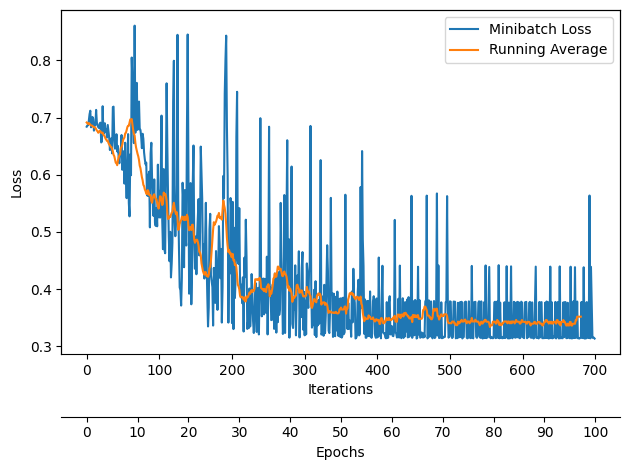

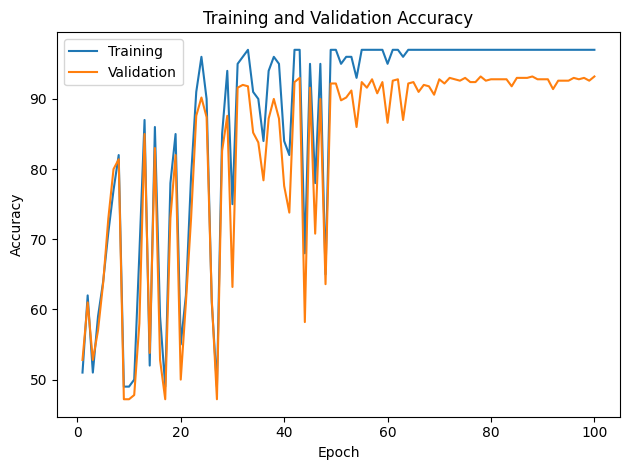

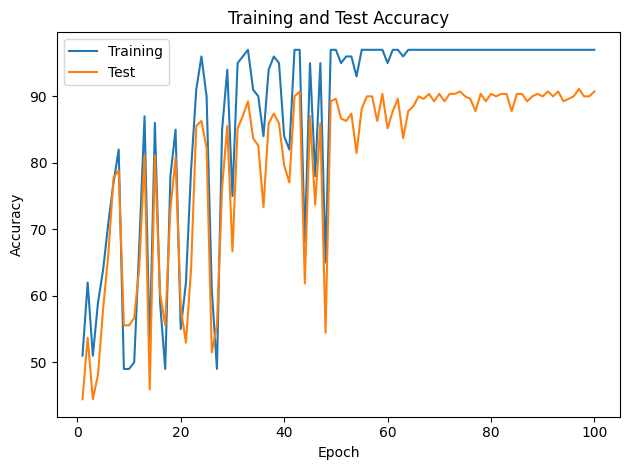

In [ ]:
plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                   num_epochs=NUM_EPOCHS,
                   iter_per_epoch=len(train_loader),
                   averaging_iterations=20)

plot_accuracy_val(train_acc_list, val_acc_list)

plot_accuracy_test(train_acc_list, test_acc_list)

# **Model with Exponential Learning Rate**

In [ ]:
NUM_EPOCHS = 100
BATCH_SIZE = 16
LEARNING_RATE = 0.1
GAMMA = 0.95

In [ ]:
# Define transformation: resize, grayscale, and tensor conversion.
transform = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

# Create train, val and test datasets
full_dataset = datasets.Caltech101(root='./data', download=True, transform=transform)

# we are going to use only these two classes
selected_classes = ['Faces', 'Faces_easy']
indices = [i for i, (img, label) in enumerate(full_dataset) if full_dataset.categories[label] in selected_classes]
subset = Subset(full_dataset, indices)
train_dataset, val_dataset, test_dataset = random_split(subset, [100, 500, 270])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Model
class LogisticRegression(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LogisticRegression, self).__init__()
        self.fc1 = nn.Linear(input_size, 15)
        self.fc2 = nn.Linear(15, 45)
        self.fc3 = nn.Linear(45, num_classes)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x) # activation 1
        x = self.fc2(x)
        x = self.relu(x) # activation 2
        x = self.fc3(x)
        return x

# Instantiate the model
input_size = 32 * 32 * 1  # Input size of the images
num_classes = 2  # Number of classes
model = LogisticRegression(input_size, num_classes)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=GAMMA)

model.to(DEVICE)

start_time = time.time()
iter_per_epoch = len(train_loader)
minibatch_loss_list, train_acc_list, val_acc_list, test_acc_list = [], [], [], []

for epoch in range(NUM_EPOCHS):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)

        # Forward pass
        logits = model(features)
        loss = criterion(logits, targets)

        # Zero gradients, backprop, and update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        minibatch_loss_list.append(loss.item())
        if batch_idx % 50 == 0:
            print(f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} '
                  f'| Batch {batch_idx:04d}/{len(train_loader):04d} '
                  f'| Loss: {loss.item():.4f}')
    scheduler.step()
    # Evaluate on training and validation sets
    model.eval()
    with torch.no_grad():
        train_acc = compute_accuracy(model, train_loader, device=DEVICE)
        test_acc = compute_accuracy(model, test_loader, device=DEVICE)
        val_acc = compute_accuracy(model, val_loader, device=DEVICE)
        print(f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} '
              f'| Train Acc: {train_acc:.2f}% '
              f'| Test Acc: {test_acc:.2f}%')
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        val_acc_list.append(val_acc)

    elapsed = (time.time() - start_time) / 60
    print(f'Time elapsed: {elapsed:.2f} min')

elapsed = (time.time() - start_time) / 60
print(f'Total Training Time: {elapsed:.2f} min')

# Evaluate on the test set
test_acc = compute_accuracy(model, test_loader, device=DEVICE)
print(f'Test Accuracy: {test_acc:.2f}%')

Files already downloaded and verified
Epoch: 001/100 | Batch 0000/0007 | Loss: 0.7130
Epoch: 001/100 | Train Acc: 49.00% | Test Acc: 51.48%
Time elapsed: 0.03 min
Epoch: 002/100 | Batch 0000/0007 | Loss: 0.6868
Epoch: 002/100 | Train Acc: 49.00% | Test Acc: 51.48%
Time elapsed: 0.06 min
Epoch: 003/100 | Batch 0000/0007 | Loss: 0.6843
Epoch: 003/100 | Train Acc: 51.00% | Test Acc: 48.52%
Time elapsed: 0.09 min
Epoch: 004/100 | Batch 0000/0007 | Loss: 0.6799
Epoch: 004/100 | Train Acc: 68.00% | Test Acc: 61.11%
Time elapsed: 0.11 min
Epoch: 005/100 | Batch 0000/0007 | Loss: 0.6699
Epoch: 005/100 | Train Acc: 49.00% | Test Acc: 51.48%
Time elapsed: 0.14 min
Epoch: 006/100 | Batch 0000/0007 | Loss: 0.7156
Epoch: 006/100 | Train Acc: 78.00% | Test Acc: 77.04%
Time elapsed: 0.16 min
Epoch: 007/100 | Batch 0000/0007 | Loss: 0.6509
Epoch: 007/100 | Train Acc: 51.00% | Test Acc: 48.15%
Time elapsed: 0.19 min
Epoch: 008/100 | Batch 0000/0007 | Loss: 0.6704
Epoch: 008/100 | Train Acc: 51.00% | Te

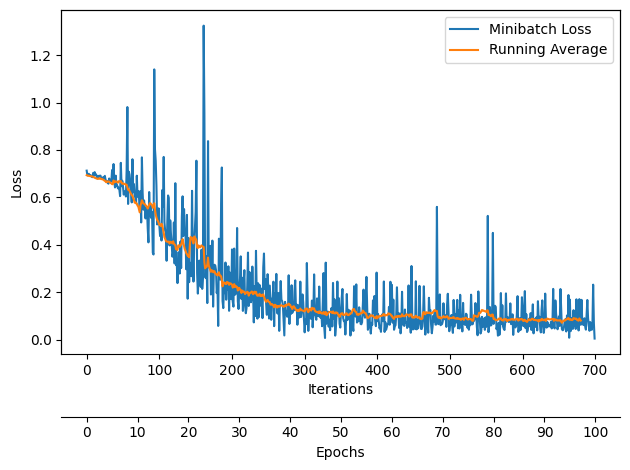

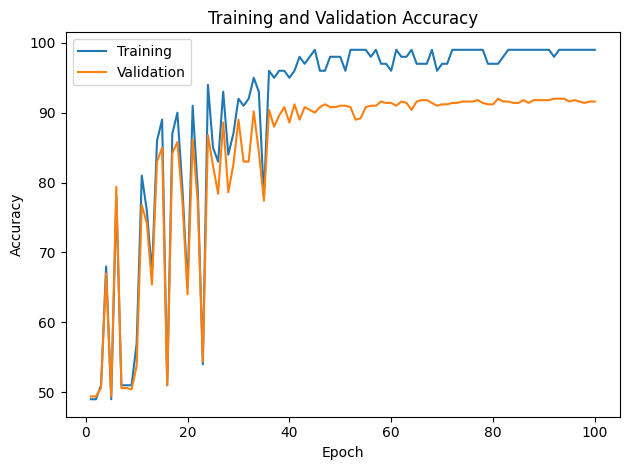

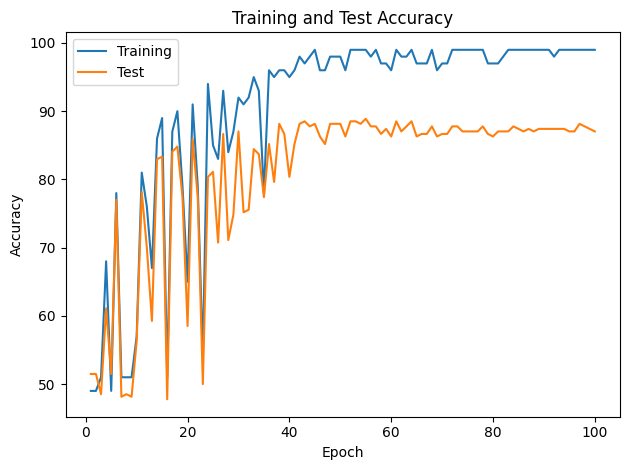

In [ ]:
plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                   num_epochs=NUM_EPOCHS,
                   iter_per_epoch=len(train_loader),
                   averaging_iterations=20)

plot_accuracy_val(train_acc_list, val_acc_list)

plot_accuracy_test(train_acc_list, test_acc_list)

# **Model with ReduceLROnPlateau**

In [ ]:
NUM_EPOCHS = 100
BATCH_SIZE = 16
LEARNING_RATE = 0.1
FACTOR = 0.1
PATIENCE = 5

In [ ]:
# Define transformation: resize, grayscale, and tensor conversion.
transform = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

# Create train, val and test datasets
full_dataset = datasets.Caltech101(root='./data', download=True, transform=transform)

# we are going to use only these two classes
selected_classes = ['Faces', 'Faces_easy']
indices = [i for i, (img, label) in enumerate(full_dataset) if full_dataset.categories[label] in selected_classes]
subset = Subset(full_dataset, indices)
train_dataset, val_dataset, test_dataset = random_split(subset, [100, 500, 270])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Model
class LogisticRegression(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LogisticRegression, self).__init__()
        self.fc1 = nn.Linear(input_size, 15)
        self.fc2 = nn.Linear(15, 45)
        self.fc3 = nn.Linear(45, num_classes)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x) # activation 1
        x = self.fc2(x)
        x = self.relu(x) # activation 2
        x = self.fc3(x)
        return x

# Instantiate the model
input_size = 32 * 32 * 1  # Input size of the images
num_classes = 2  # Number of classes
model = LogisticRegression(input_size, num_classes)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=FACTOR, patience=PATIENCE)

model.to(DEVICE)

start_time = time.time()
iter_per_epoch = len(train_loader)
minibatch_loss_list, train_acc_list, val_acc_list, test_acc_list = [], [], [], []

for epoch in range(NUM_EPOCHS):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)

        # Forward pass
        logits = model(features)
        loss = criterion(logits, targets)

        # Zero gradients, backprop, and update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        minibatch_loss_list.append(loss.item())
        if batch_idx % 50 == 0:
            print(f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} '
                  f'| Batch {batch_idx:04d}/{len(train_loader):04d} '
                  f'| Loss: {loss.item():.4f}')
    # Evaluate on training and validation sets
    model.eval()
    with torch.no_grad():
        train_acc = compute_accuracy(model, train_loader, device=DEVICE)
        test_acc = compute_accuracy(model, test_loader, device=DEVICE)
        val_acc = compute_accuracy(model, val_loader, device=DEVICE)
        print(f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} '
              f'| Train Acc: {train_acc:.2f}% '
              f'| Test Acc: {test_acc:.2f}%')
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        val_acc_list.append(val_acc)

    elapsed = (time.time() - start_time) / 60
    print(f'Time elapsed: {elapsed:.2f} min')

    scheduler.step(minibatch_loss_list[-1])

elapsed = (time.time() - start_time) / 60
print(f'Total Training Time: {elapsed:.2f} min')

# Evaluate on the test set
test_acc = compute_accuracy(model, test_loader, device=DEVICE)
print(f'Test Accuracy: {test_acc:.2f}%')

Files already downloaded and verified
Epoch: 001/100 | Batch 0000/0007 | Loss: 0.6916
Epoch: 001/100 | Train Acc: 52.00% | Test Acc: 47.41%
Time elapsed: 0.03 min
Epoch: 002/100 | Batch 0000/0007 | Loss: 0.8748
Epoch: 002/100 | Train Acc: 52.00% | Test Acc: 47.41%
Time elapsed: 0.05 min
Epoch: 003/100 | Batch 0000/0007 | Loss: 0.7525
Epoch: 003/100 | Train Acc: 48.00% | Test Acc: 52.59%
Time elapsed: 0.08 min
Epoch: 004/100 | Batch 0000/0007 | Loss: 0.7256
Epoch: 004/100 | Train Acc: 83.00% | Test Acc: 75.19%
Time elapsed: 0.10 min
Epoch: 005/100 | Batch 0000/0007 | Loss: 0.6688
Epoch: 005/100 | Train Acc: 52.00% | Test Acc: 47.41%
Time elapsed: 0.13 min
Epoch: 006/100 | Batch 0000/0007 | Loss: 0.6082
Epoch: 006/100 | Train Acc: 84.00% | Test Acc: 86.30%
Time elapsed: 0.15 min
Epoch: 007/100 | Batch 0000/0007 | Loss: 0.6035
Epoch: 007/100 | Train Acc: 85.00% | Test Acc: 87.41%
Time elapsed: 0.19 min
Epoch: 008/100 | Batch 0000/0007 | Loss: 0.5939
Epoch: 008/100 | Train Acc: 85.00% | Te

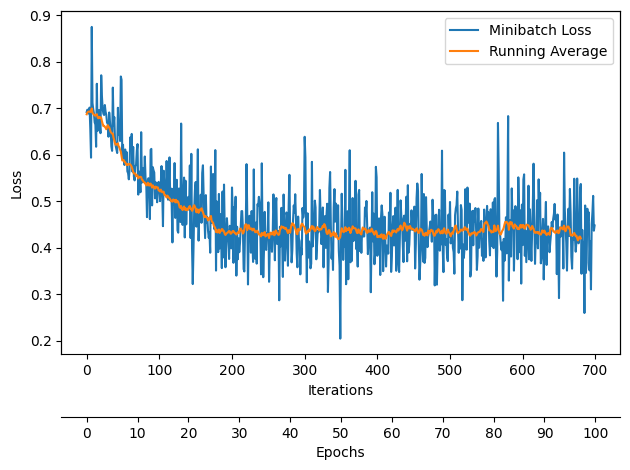

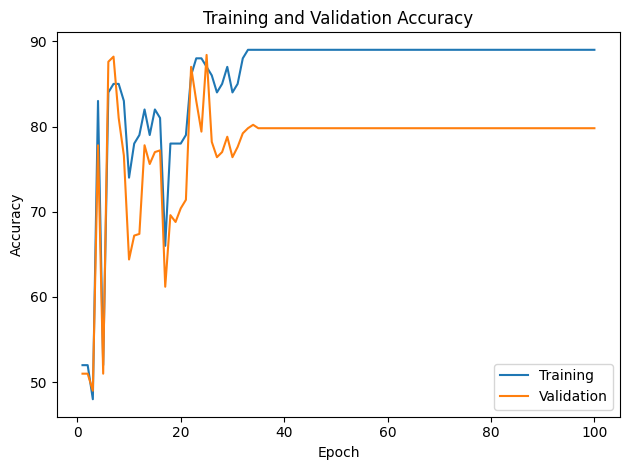

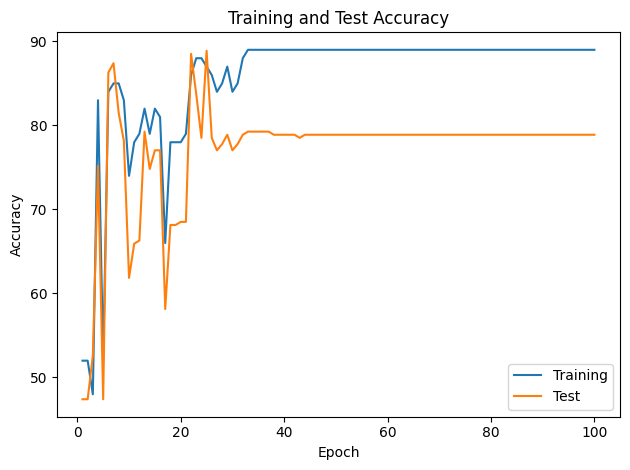

In [ ]:
plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                   num_epochs=NUM_EPOCHS,
                   iter_per_epoch=len(train_loader),
                   averaging_iterations=20)

plot_accuracy_val(train_acc_list, val_acc_list)

plot_accuracy_test(train_acc_list, test_acc_list)

# **Model with SGD without Momentum**

In [ ]:
NUM_EPOCHS = 100
BATCH_SIZE = 64
LEARNING_RATE = 0.005

In [ ]:
# Define transformation: resize, grayscale, and tensor conversion.
transform = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

# Create train, val and test datasets
full_dataset = datasets.Caltech101(root='./data', download=True, transform=transform)

# we are going to use only these two classes
selected_classes = ['Faces', 'Faces_easy']
indices = [i for i, (img, label) in enumerate(full_dataset) if full_dataset.categories[label] in selected_classes]
subset = Subset(full_dataset, indices)
train_dataset, val_dataset, test_dataset = random_split(subset, [100, 500, 270])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Model
class LogisticRegression(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LogisticRegression, self).__init__()
        self.fc1 = nn.Linear(input_size, 15)
        self.fc2 = nn.Linear(15, 45)
        self.fc3 = nn.Linear(45, num_classes)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x) # activation 1
        x = self.fc2(x)
        x = self.relu(x) # activation 2
        x = self.fc3(x)
        return x

# Instantiate the model
input_size = 32 * 32 * 1  # Input size of the images
num_classes = 2  # Number of classes
model = LogisticRegression(input_size, num_classes)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)

model.to(DEVICE)

start_time = time.time()
iter_per_epoch = len(train_loader)
minibatch_loss_list, train_acc_list, val_acc_list, test_acc_list = [], [], [], []

for epoch in range(NUM_EPOCHS):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)

        # Forward pass
        logits = model(features)
        loss = criterion(logits, targets)

        # Zero gradients, backprop, and update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        minibatch_loss_list.append(loss.item())
        if batch_idx % 50 == 0:
            print(f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} '
                  f'| Batch {batch_idx:04d}/{len(train_loader):04d} '
                  f'| Loss: {loss.item():.4f}')
    # Evaluate on training and validation sets
    model.eval()
    with torch.no_grad():
        train_acc = compute_accuracy(model, train_loader, device=DEVICE)
        test_acc = compute_accuracy(model, test_loader, device=DEVICE)
        val_acc = compute_accuracy(model, val_loader, device=DEVICE)
        print(f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} '
              f'| Train Acc: {train_acc:.2f}% '
              f'| Test Acc: {test_acc:.2f}%')
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        val_acc_list.append(val_acc)

    elapsed = (time.time() - start_time) / 60
    print(f'Time elapsed: {elapsed:.2f} min')


elapsed = (time.time() - start_time) / 60
print(f'Total Training Time: {elapsed:.2f} min')

# Evaluate on the test set
test_acc = compute_accuracy(model, test_loader, device=DEVICE)
print(f'Test Accuracy: {test_acc:.2f}%')

Files already downloaded and verified
Epoch: 001/100 | Batch 0000/0002 | Loss: 0.6936
Epoch: 001/100 | Train Acc: 54.00% | Test Acc: 47.04%
Time elapsed: 0.02 min
Epoch: 002/100 | Batch 0000/0002 | Loss: 0.6919
Epoch: 002/100 | Train Acc: 54.00% | Test Acc: 47.04%
Time elapsed: 0.05 min
Epoch: 003/100 | Batch 0000/0002 | Loss: 0.7025
Epoch: 003/100 | Train Acc: 54.00% | Test Acc: 47.04%
Time elapsed: 0.07 min
Epoch: 004/100 | Batch 0000/0002 | Loss: 0.7054
Epoch: 004/100 | Train Acc: 54.00% | Test Acc: 47.04%
Time elapsed: 0.10 min
Epoch: 005/100 | Batch 0000/0002 | Loss: 0.6863
Epoch: 005/100 | Train Acc: 54.00% | Test Acc: 47.04%
Time elapsed: 0.12 min
Epoch: 006/100 | Batch 0000/0002 | Loss: 0.6946
Epoch: 006/100 | Train Acc: 54.00% | Test Acc: 47.04%
Time elapsed: 0.16 min
Epoch: 007/100 | Batch 0000/0002 | Loss: 0.6990
Epoch: 007/100 | Train Acc: 54.00% | Test Acc: 47.04%
Time elapsed: 0.18 min
Epoch: 008/100 | Batch 0000/0002 | Loss: 0.6772
Epoch: 008/100 | Train Acc: 54.00% | Te

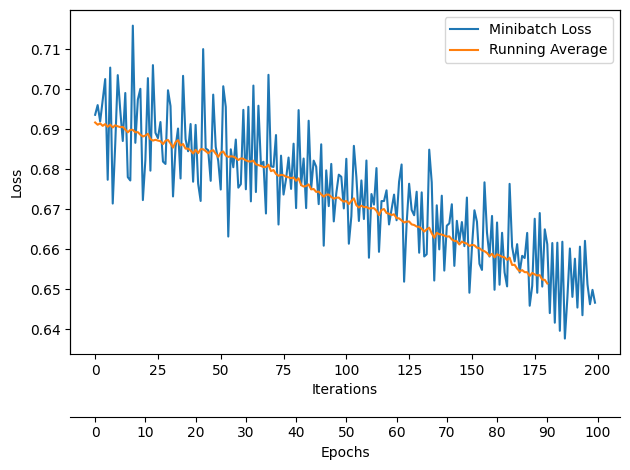

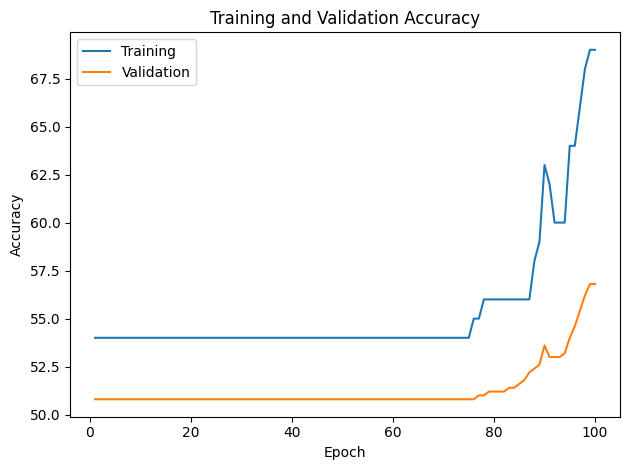

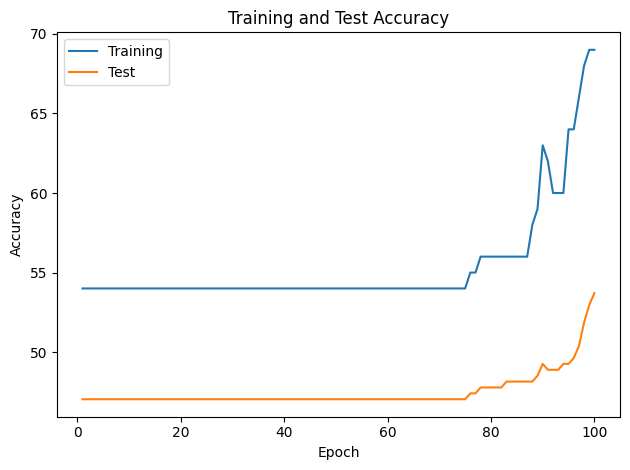

In [ ]:
plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                   num_epochs=NUM_EPOCHS,
                   iter_per_epoch=len(train_loader),
                   averaging_iterations=20)

plot_accuracy_val(train_acc_list, val_acc_list)

plot_accuracy_test(train_acc_list, test_acc_list)

# **Model with SGD with Momentum**

In [ ]:
NUM_EPOCHS = 100
BATCH_SIZE = 64
LEARNING_RATE = 0.005
MOMENTUM = 0.99

In [ ]:
# Define transformation: resize, grayscale, and tensor conversion.
transform = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

# Create train, val and test datasets
full_dataset = datasets.Caltech101(root='./data', download=True, transform=transform)

# we are going to use only these two classes
selected_classes = ['Faces', 'Faces_easy']
indices = [i for i, (img, label) in enumerate(full_dataset) if full_dataset.categories[label] in selected_classes]
subset = Subset(full_dataset, indices)
train_dataset, val_dataset, test_dataset = random_split(subset, [100, 500, 270])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Model
class LogisticRegression(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LogisticRegression, self).__init__()
        self.fc1 = nn.Linear(input_size, 15)
        self.fc2 = nn.Linear(15, 45)
        self.fc3 = nn.Linear(45, num_classes)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x) # activation 1
        x = self.fc2(x)
        x = self.relu(x) # activation 2
        x = self.fc3(x)
        return x

# Instantiate the model
input_size = 32 * 32 * 1  # Input size of the images
num_classes = 2  # Number of classes
model = LogisticRegression(input_size, num_classes)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

model.to(DEVICE)

start_time = time.time()
iter_per_epoch = len(train_loader)
minibatch_loss_list, train_acc_list, val_acc_list, test_acc_list = [], [], [], []

for epoch in range(NUM_EPOCHS):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)

        # Forward pass
        logits = model(features)
        loss = criterion(logits, targets)

        # Zero gradients, backprop, and update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        minibatch_loss_list.append(loss.item())
        if batch_idx % 50 == 0:
            print(f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} '
                  f'| Batch {batch_idx:04d}/{len(train_loader):04d} '
                  f'| Loss: {loss.item():.4f}')
    # Evaluate on training and validation sets
    model.eval()
    with torch.no_grad():
        train_acc = compute_accuracy(model, train_loader, device=DEVICE)
        test_acc = compute_accuracy(model, test_loader, device=DEVICE)
        val_acc = compute_accuracy(model, val_loader, device=DEVICE)
        print(f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} '
              f'| Train Acc: {train_acc:.2f}% '
              f'| Test Acc: {test_acc:.2f}%')
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        val_acc_list.append(val_acc)

    elapsed = (time.time() - start_time) / 60
    print(f'Time elapsed: {elapsed:.2f} min')


elapsed = (time.time() - start_time) / 60
print(f'Total Training Time: {elapsed:.2f} min')

# Evaluate on the test set
test_acc = compute_accuracy(model, test_loader, device=DEVICE)
print(f'Test Accuracy: {test_acc:.2f}%')

Files already downloaded and verified
Epoch: 001/100 | Batch 0000/0002 | Loss: 0.6874
Epoch: 001/100 | Train Acc: 49.00% | Test Acc: 48.15%
Time elapsed: 0.03 min
Epoch: 002/100 | Batch 0000/0002 | Loss: 0.6881
Epoch: 002/100 | Train Acc: 49.00% | Test Acc: 48.15%
Time elapsed: 0.05 min
Epoch: 003/100 | Batch 0000/0002 | Loss: 0.6917
Epoch: 003/100 | Train Acc: 48.00% | Test Acc: 48.15%
Time elapsed: 0.07 min
Epoch: 004/100 | Batch 0000/0002 | Loss: 0.6966
Epoch: 004/100 | Train Acc: 54.00% | Test Acc: 56.30%
Time elapsed: 0.12 min
Epoch: 005/100 | Batch 0000/0002 | Loss: 0.6853
Epoch: 005/100 | Train Acc: 65.00% | Test Acc: 62.22%
Time elapsed: 0.15 min
Epoch: 006/100 | Batch 0000/0002 | Loss: 0.6835
Epoch: 006/100 | Train Acc: 68.00% | Test Acc: 65.56%
Time elapsed: 0.17 min
Epoch: 007/100 | Batch 0000/0002 | Loss: 0.6815
Epoch: 007/100 | Train Acc: 73.00% | Test Acc: 69.26%
Time elapsed: 0.20 min
Epoch: 008/100 | Batch 0000/0002 | Loss: 0.6783
Epoch: 008/100 | Train Acc: 76.00% | Te

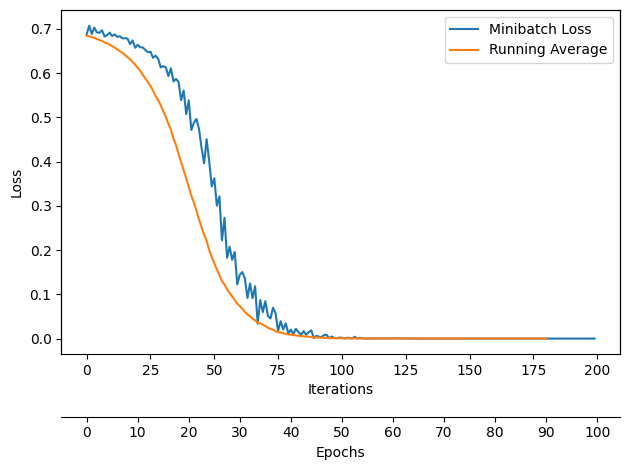

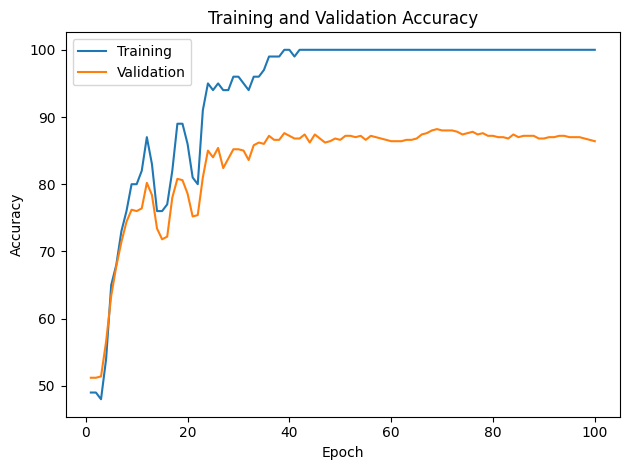

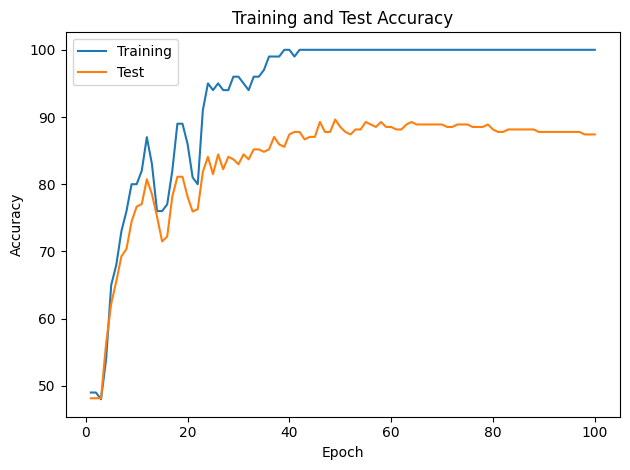

In [ ]:
plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                   num_epochs=NUM_EPOCHS,
                   iter_per_epoch=len(train_loader),
                   averaging_iterations=20)

plot_accuracy_val(train_acc_list, val_acc_list)

plot_accuracy_test(train_acc_list, test_acc_list)

# **Model with Adam**

In [ ]:
NUM_EPOCHS = 100
BATCH_SIZE = 64
LEARNING_RATE = 0.005

In [ ]:
# Define transformation: resize, grayscale, and tensor conversion.
transform = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

# Create train, val and test datasets
full_dataset = datasets.Caltech101(root='./data', download=True, transform=transform)

# we are going to use only these two classes
selected_classes = ['Faces', 'Faces_easy']
indices = [i for i, (img, label) in enumerate(full_dataset) if full_dataset.categories[label] in selected_classes]
subset = Subset(full_dataset, indices)
train_dataset, val_dataset, test_dataset = random_split(subset, [100, 500, 270])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Model
class LogisticRegression(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LogisticRegression, self).__init__()
        self.fc1 = nn.Linear(input_size, 15)
        self.fc2 = nn.Linear(15, 45)
        self.fc3 = nn.Linear(45, num_classes)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x) # activation 1
        x = self.fc2(x)
        x = self.relu(x) # activation 2
        x = self.fc3(x)
        return x

# Instantiate the model
input_size = 32 * 32 * 1  # Input size of the images
num_classes = 2  # Number of classes
model = LogisticRegression(input_size, num_classes)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

model.to(DEVICE)

start_time = time.time()
iter_per_epoch = len(train_loader)
minibatch_loss_list, train_acc_list, val_acc_list, test_acc_list = [], [], [], []

for epoch in range(NUM_EPOCHS):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)

        # Forward pass
        logits = model(features)
        loss = criterion(logits, targets)

        # Zero gradients, backprop, and update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        minibatch_loss_list.append(loss.item())
        if batch_idx % 50 == 0:
            print(f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} '
                  f'| Batch {batch_idx:04d}/{len(train_loader):04d} '
                  f'| Loss: {loss.item():.4f}')
    # Evaluate on training and validation sets
    model.eval()
    with torch.no_grad():
        train_acc = compute_accuracy(model, train_loader, device=DEVICE)
        test_acc = compute_accuracy(model, test_loader, device=DEVICE)
        val_acc = compute_accuracy(model, val_loader, device=DEVICE)
        print(f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} '
              f'| Train Acc: {train_acc:.2f}% '
              f'| Test Acc: {test_acc:.2f}%')
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        val_acc_list.append(val_acc)

    elapsed = (time.time() - start_time) / 60
    print(f'Time elapsed: {elapsed:.2f} min')


elapsed = (time.time() - start_time) / 60
print(f'Total Training Time: {elapsed:.2f} min')

# Evaluate on the test set
test_acc = compute_accuracy(model, test_loader, device=DEVICE)
print(f'Test Accuracy: {test_acc:.2f}%')

Files already downloaded and verified
Epoch: 001/100 | Batch 0000/0002 | Loss: 0.6922
Epoch: 001/100 | Train Acc: 52.00% | Test Acc: 52.59%
Time elapsed: 0.03 min
Epoch: 002/100 | Batch 0000/0002 | Loss: 0.6812
Epoch: 002/100 | Train Acc: 48.00% | Test Acc: 47.41%
Time elapsed: 0.05 min
Epoch: 003/100 | Batch 0000/0002 | Loss: 0.6975
Epoch: 003/100 | Train Acc: 52.00% | Test Acc: 52.59%
Time elapsed: 0.08 min
Epoch: 004/100 | Batch 0000/0002 | Loss: 0.6695
Epoch: 004/100 | Train Acc: 52.00% | Test Acc: 52.96%
Time elapsed: 0.11 min
Epoch: 005/100 | Batch 0000/0002 | Loss: 0.6205
Epoch: 005/100 | Train Acc: 77.00% | Test Acc: 68.52%
Time elapsed: 0.14 min
Epoch: 006/100 | Batch 0000/0002 | Loss: 0.6124
Epoch: 006/100 | Train Acc: 83.00% | Test Acc: 81.85%
Time elapsed: 0.16 min
Epoch: 007/100 | Batch 0000/0002 | Loss: 0.5621
Epoch: 007/100 | Train Acc: 64.00% | Test Acc: 58.15%
Time elapsed: 0.19 min
Epoch: 008/100 | Batch 0000/0002 | Loss: 0.5537
Epoch: 008/100 | Train Acc: 84.00% | Te

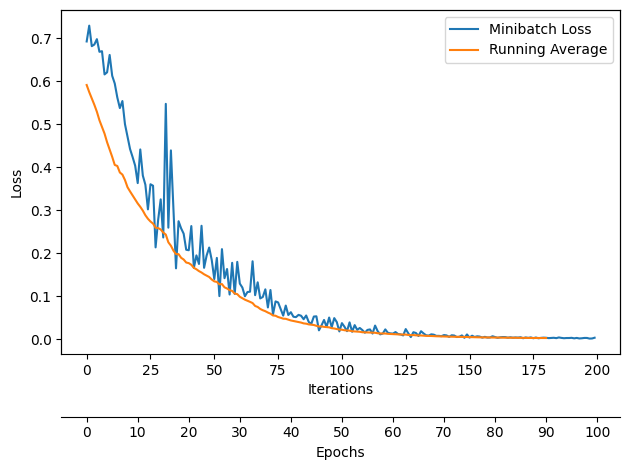

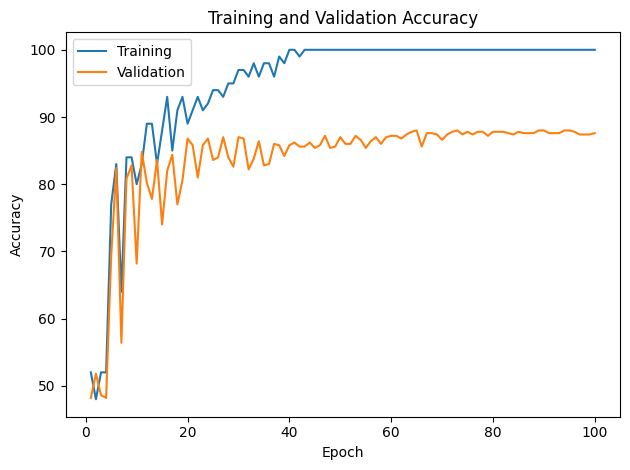

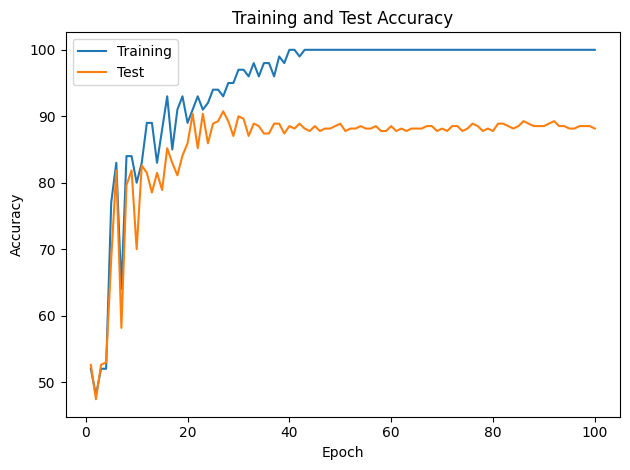

In [ ]:
plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                   num_epochs=NUM_EPOCHS,
                   iter_per_epoch=len(train_loader),
                   averaging_iterations=20)

plot_accuracy_val(train_acc_list, val_acc_list)

plot_accuracy_test(train_acc_list, test_acc_list)